  0%|          | 0/4 [00:00<?, ?it/s]

δ =  0.5
True chgpts = [ 75 175]


  0%|          | 0/10 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:22<01:06, 22.17s/it]

δ =  0.75
True chgpts = [112 262]


  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:58<01:01, 30.78s/it]

δ =  1.0
True chgpts = [150 350]


  0%|          | 0/10 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [01:55<00:42, 42.65s/it]

δ =  1.25
True chgpts = [187 437]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:20<00:00, 50.23s/it]


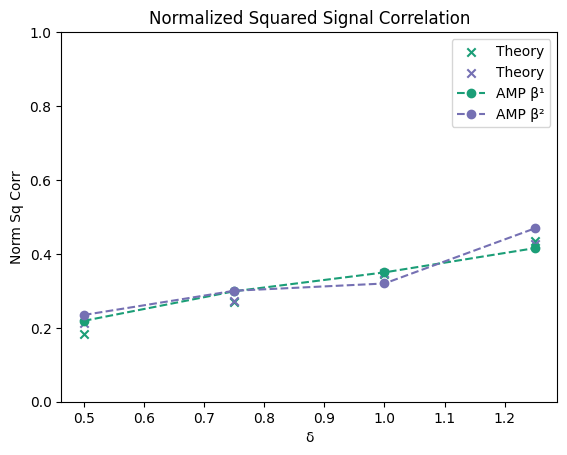

(0.0, 0.4)

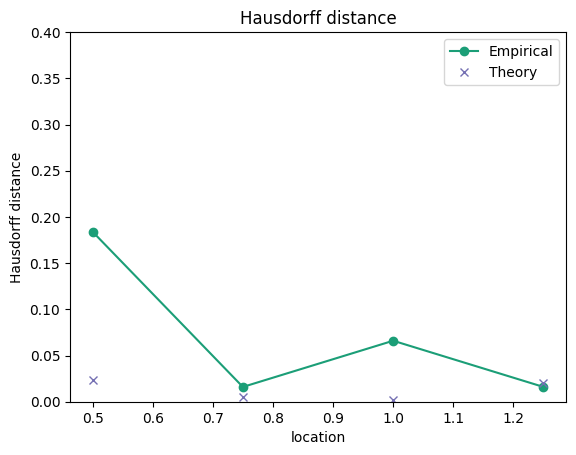

In [6]:
import numpy as np
import jax.numpy as jnp # Not used in any randomness, all randomness is in numpy
import jax
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean, SE_fixed_C, GAMP
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_configuration import C_to_chgpt, generate_C_distanced, unif_prior_to_η_ϕ
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from amp.posterior import MAP, MAP_η, compute_posterior, posterior_over_η, η_to_ψ
from amp.marginal_separable_jax import GAMP_gaussian_clean, GAMP_real_data, q
from amp.signal_priors import GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# np.random.seed(1)

p = 500
σ = 0.1 # noise standard deviation
L = 3 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
δ_list = [0.5, 0.75, 1.0, 1.25]

chgpt_locations = np.array([0.3, 0.7])

corr_1_list = []
corr_2_list = []
corr_1_SE_list = []
corr_2_SE_list = []
AMP_hausdorff_list = []
theory_hausdorff_list = []

np.random.seed(1)


for i in tqdm(range(len(δ_list))):
    δ = δ_list[i]
    print("δ = ", δ)

    n = int(δ * p)
    true_chgpt_locations = lambda n: (n * chgpt_locations).astype(int)

    # --- Preliminaries ---
    # Changepoint locations
    Δ = lambda n: int(n/10)
    Lmin = 1
    Lmax = 3
    num_valid_configs, η_arr, p_η_arr, ϕ = unif_prior_to_η_ϕ(Lmin, Lmax, Δ(n), n) # Lxn matrix
    assert η_arr.shape == (num_valid_configs, Lmax-1) and \
        len(p_η_arr) == num_valid_configs
    assert ϕ.shape == (Lmax, n)

    print(f"True chgpts = {true_chgpt_locations(n)}")
    C_true = η_to_ψ(true_chgpt_locations(n), n)
    η_true = true_chgpt_locations(n)

    # Gaussian Signal Prior
    B̃_cov = np.eye(L)
    B̃_cov[0, 1] = 0.5
    B̃_cov[1, 0] = 0.5
    signal_prior = GaussianSignal(B̃_cov)

    # Sparse Gaussian Signal Prior
    # α = 0.6 # fraction of nonzeros
    # σ_l_arr = np.array([1.0, 1.0, 1.0]) # signal standard deviation
    # signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)

    # Sparse Difference Signal Prior
    # α = 0.25 # fraction of nonzeros
    # var_β_1 = 1
    # σ_w = 1
    # signal_prior = SparseDiffSignal(var_β_1, σ_w, α, L)

    # Soft threshold denoiser 
    # σ_l_arr = np.array([1.0, 1.0, 1.0]) # signal standard deviation
    # α = 0.5 # fraction of nonzeros
    # signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)
    # st_ζ = 0.5 # The scaling factor in front of the effective noise std in the threshold
    # if using soft thresholding, set st_ζ != None in the GAMP_full function.

    B̃ = signal_prior.sample(p)
    B̂_0 = signal_prior.sample(p)

    ρ = 1/δ * 1/p * B̃.T @ B̃

    # Generate the observation vector Y
    X = np.random.normal(0, np.sqrt(1/n), (n, p))
    Θ = X @ B̃
    Y = q(Θ, C_true, σ) 

    B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, ν_fixed_arr, κ_T_fixed_arr, ν̂_fixed_arr, κ_B_fixed_arr = GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T, B̂_0, signal_prior, signal_prior, st_ζ = None, verbose = False, seed = None, tqdm_disable = False)
    ν = ν_arr[-1]
    κ_T = κ_T_arr[-1]
    ν_fixed = ν_fixed_arr[-1]
    κ_T_fixed = κ_T_fixed_arr[-1]

    corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
    corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
    corr_1_SE_list.append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0]))
    corr_2_SE_list.append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))

    # --- Compute the posterior and MAP estimate using the output of AMP --- #
    post_Θ_Y = posterior_over_η(η_arr, p_η_arr, Θ_t, Y, jnp.array(ρ), σ, ν, κ_T)
    AMP_η_MAP = amp.posterior.MAP_η(η_arr, post_Θ_Y)
    AMP_hausdorff_list.append((1/n) * amp.performance_measures.hausdorff(AMP_η_MAP, η_true))

    # --- Compute the theoretical Hausdorff error prediction --- #
    Z_i = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
    V_Θ_i = (Z_i @ np.linalg.inv(ρ) @ ν_fixed + jnp.array(nprandom.multivariate_normal(
        jnp.zeros(L), κ_T_fixed, size=n))).reshape(n, L)
    post_V_q = posterior_over_η(η_arr, p_η_arr, V_Θ_i, q(Z_i, C_true, σ), jnp.array(ρ), σ, ν, κ_T)
    theory_η_MAP = amp.posterior.MAP_η(η_arr, post_V_q)
    theory_hausdorff_list.append((1/n) * amp.performance_measures.hausdorff(theory_η_MAP, η_true))


# Sqcorr plots
plt.errorbar(δ_list, (corr_1_list), label="AMP β¹", marker="o", ls="--", c=PAL[0], alpha = 1.0)
plt.errorbar(δ_list, (corr_2_list), label="AMP β²", marker="o", ls="--", c=PAL[2], alpha = 1.0)
plt.scatter(δ_list,corr_1_SE_list, label="Theory", marker="x", alpha = 1.0, c=PAL[0])
plt.scatter(δ_list, corr_2_SE_list, label="Theory", marker="x", alpha = 1.0, c=PAL[2])
plt.ylim((0, 1))
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.title("Normalized Squared Signal Correlation")
plt.legend()
plt.show()

# Hausdorff plots
plt.errorbar(δ_list, AMP_hausdorff_list, label="Empirical", marker="o", ls="-", c=PAL[0], alpha = 1)
plt.errorbar(δ_list, theory_hausdorff_list, label="Theory", marker="x", ls="", c=PAL[2], alpha = 1)
plt.xlabel("location")
plt.ylabel("Hausdorff distance")
plt.title("Hausdorff distance")
plt.legend()
plt.ylim((0, 0.4))